In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
BASE_DIR=os.path.dirname(os.getcwd())
import pandas as pd
import sys
sys.path.append(BASE_DIR)
import torch

import scipy.stats
from scipy.stats import norm
from scipy.special import logsumexp

from vae.utils.modelIO import save_model, load_model, load_metadata
from notebooks.utils import PlotParams

In [2]:
plotter = PlotParams()
plotter.set_params()
DATA_DIR = os.path.join(os.pardir, 'data')
FIG_DIR = os.path.join(os.pardir, 'figs')
RES_DIR = os.path.join(os.pardir, 'results')

In [3]:
X_test = np.load(os.path.join(DATA_DIR, 'dsprites', 'dsprite_train.npz'))['imgs']
X_test = torch.tensor(X_test).unsqueeze(1).float() / 255.0
digit_size = 64
dataset = 'dsprites'

# dataset = 'fashion'
# X_test = torch.load(os.path.join(DATA_DIR, 'fashionMnist', 'FashionMNIST', 'processed', 'test.pt'))

# dataset = 'mnist_bern'
# X_test = torch.load(os.path.join(DATA_DIR, 'mnist', 'MNIST', 'processed', 'test.pt'))

# X_test = X_test[0].unsqueeze(1).float() / 255.0

# dataset = 'bmnist'
# X_test = np.loadtxt(os.path.join(DATA_DIR, 'bmnist', 'binarized_mnist_test.amat'))
# X_test = torch.tensor(X_test.reshape((-1, 28, 28)))
# X_test = X_test.unsqueeze(1).float() / 255.0

# X_test = torch.nn.functional.pad(X_test, pad=(2, 2, 2, 2))
digit_size = 64

X_test = X_test[:10000]

In [4]:
def bootstrap(x, low, high, n_samples):
	mu = x.mean()
	n = len(x)
	X = np.random.choice(x, size=n_samples*n).reshape(n_samples, n)
	mu_star = X.mean(axis=1)
	d_star = np.sort(mu_star - mu)

	return mu, mu + d_star[int(low*n_samples)], mu + d_star[int(high*n_samples)]

In [5]:
def compute_samples(model, data, num_samples, debug=False):
    """ Sample from importance distribution z_samples ~ q(z|X) and
        compute p(z_samples), q(z_samples) for importance sampling
    """
    data = data.cuda()
    z_mean, z_log_sigma = model.encoder(data)
    z_mean = z_mean.cpu().detach().numpy()
    z_log_sigma = z_log_sigma.cpu().detach().numpy()
    z_samples = []
    qz = []

    for m, s in zip(z_mean, z_log_sigma):
        z_vals = [np.random.normal(m[i], np.exp(s[i]), num_samples) for i in range(len(m))]
        qz_vals = [norm.pdf(z_vals[i], loc=m[i], scale=np.exp(s[i])) for i in range(len(m))]
        z_samples.append(z_vals)
        qz.append(qz_vals)

    z_samples = np.array(z_samples)
    pz = norm.pdf(z_samples)
    qz = np.array(qz)

    z_samples = np.swapaxes(z_samples, 1, 2)
    pz = np.swapaxes(pz, 1, 2)
    qz = np.swapaxes(qz, 1, 2)

    return z_samples, pz, qz

In [6]:
def estimate_logpx_batch(model, data, num_samples, debug=False):
    z_samples, pz, qz = compute_samples(model, data, num_samples)
    assert len(z_samples) == len(data)
    assert len(z_samples) == len(pz)
    assert len(z_samples) == len(qz)
    z_samples = torch.tensor(z_samples).float().cuda()

    result = []
    for i in range(len(data)):
        x_predict = model.decoder(z_samples[i]).reshape(-1, digit_size ** 2)
        x_predict = x_predict.cpu().detach().numpy()
        x_predict = np.clip(x_predict, np.finfo(float).eps, 1. - np.finfo(float).eps)
        p_vals = pz[i]
        q_vals = qz[i]

        datum = data[i].numpy().reshape(digit_size ** 2)

        # \log p(x|z) = Binary cross entropy
        logp_xz = np.sum(datum * np.log(x_predict + 1e-9) + (1. - datum) * np.log(1.0 - x_predict + 1e-9), axis=-1)
        logpz = np.sum(np.log(p_vals + 1e-9), axis=-1)
        logqz = np.sum(np.log(q_vals + 1e-9), axis=-1)
        argsum = logp_xz + logpz - logqz
        logpx = -np.log(num_samples + 1e-9) + logsumexp(argsum)
        result.append(logpx)

    return np.array(result)

In [7]:
def estimate_logpx(model, data, num_samples, verbosity=0):
    batches = []
    iterations = int(np.ceil(1. * len(data) / 100))
    for b in range(iterations):
        batch_data = data[b * 100:(b + 1) * 100]
        batches.append(estimate_logpx_batch(model, batch_data, num_samples))
        if verbosity and b % max(11 - verbosity, 1) == 0:
            print("Batch %d [%d, %d): %.2f" % (b, b * 100, (b+1) * 100, np.mean(np.concatenate(batches))))

    log_probs = np.concatenate(batches)
    mu, lb, ub = bootstrap(log_probs, 0.025, 0.975, 1000)

    return mu, lb, ub

In [8]:
alphas = np.arange(0.1, 1.0, 0.1)
model_paths = [os.path.join(RES_DIR, dataset+f'_gjs-{a:.1f}') for a in alphas]
model_paths += [os.path.join(RES_DIR, dataset+f'_dgjs-{a:.1f}') for a in alphas]
model_paths += [os.path.join(RES_DIR, dataset+'_kl')]
model_paths += [os.path.join(RES_DIR, dataset+'_kl_reverse')]
model_paths += [os.path.join(RES_DIR, dataset+'_mmd')]

# model_paths += [os.path.join(RES_DIR, 'mnist_kl')]
# model_paths += [os.path.join(RES_DIR, 'mnist_kl_reverse')]
# model_paths += [os.path.join(RES_DIR, 'mnist_mmd')]

log_probs_mu = []
log_probs_lb = []
log_probs_ub = []
log_probs_best = -np.inf

for model_path in model_paths:
    model = load_model(model_path)
    logpx_mu, logpx_lb, logpx_ub = estimate_logpx(model, X_test, num_samples=128, verbosity=0)

    log_probs_mu += [logpx_mu]
    log_probs_lb += [logpx_lb]
    log_probs_ub += [logpx_ub]

    if logpx_mu > log_probs_best:
        model_best = model_path
        log_probs_best = logpx_mu

    print(model_path)
    print("log p(x) = %.2f (%.2f, %.2f)" % (logpx_mu, logpx_lb, logpx_ub))

..\results\dsprites_gjs-0.1
log p(x) = -56.57 (-56.59, -56.54)
..\results\dsprites_gjs-0.2
log p(x) = -45.78 (-45.81, -45.75)
..\results\dsprites_gjs-0.3
log p(x) = -40.18 (-40.22, -40.15)
..\results\dsprites_gjs-0.4
log p(x) = -35.43 (-35.48, -35.37)
..\results\dsprites_gjs-0.5
log p(x) = -33.66 (-33.72, -33.60)
..\results\dsprites_gjs-0.6
log p(x) = -33.37 (-33.44, -33.31)
..\results\dsprites_gjs-0.7
log p(x) = -38.78 (-38.85, -38.69)
..\results\dsprites_gjs-0.8
log p(x) = -40.50 (-40.60, -40.40)
..\results\dsprites_gjs-0.9
log p(x) = -39.15 (-39.29, -39.02)
..\results\dsprites_dgjs-0.1
log p(x) = -63.30 (-63.33, -63.28)
..\results\dsprites_dgjs-0.2
log p(x) = -82.24 (-82.27, -82.21)
..\results\dsprites_dgjs-0.3
log p(x) = -76.53 (-76.56, -76.50)
..\results\dsprites_dgjs-0.4
log p(x) = -70.18 (-70.21, -70.15)
..\results\dsprites_dgjs-0.5
log p(x) = -65.53 (-65.55, -65.50)
..\results\dsprites_dgjs-0.6
log p(x) = -61.40 (-61.42, -61.37)
..\results\dsprites_dgjs-0.7
log p(x) = -56.84 (-

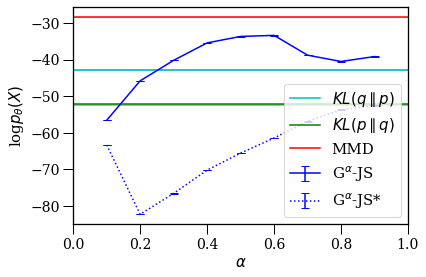

In [9]:
yerr_ub1 = np.array(log_probs_ub[:9]) - np.array(log_probs_mu[:9])
yerr_lb1 = np.array(log_probs_mu[:9]) - np.array(log_probs_lb[:9])
yerr1 = np.stack([yerr_lb1, yerr_ub1]).reshape((2, 9))

yerr_ub2 = np.array(log_probs_ub[:9]) - np.array(log_probs_mu[:9])
yerr_lb2 = np.array(log_probs_mu[:9]) - np.array(log_probs_lb[:9])
yerr2 = np.stack([yerr_lb2, yerr_ub2]).reshape((2, 9))

plt.errorbar(np.arange(0.1, 1.0, 0.1), log_probs_mu[:9], yerr=yerr1, color='b', fmt='-', capsize=4, label=r'G$^{\alpha}$-JS')
plt.errorbar(np.arange(0.1, 1.0, 0.1), log_probs_mu[9:18], yerr=yerr2, color='b', fmt=':', capsize=4, label=r'G$^{\alpha}$-JS*')
plt.plot([0.0, 1.0], [log_probs_mu[18], log_probs_mu[18]], 'c', label=r'$KL(q\parallel p)$')
plt.fill_between([0.0, 1.0], [log_probs_lb[18], log_probs_lb[18]], [log_probs_ub[18], log_probs_ub[18]], color='c', alpha=0.3)
plt.plot([0.0, 1.0], [log_probs_mu[19], log_probs_mu[19]], 'g', label=r'$KL(p\parallel q)$')
plt.fill_between([0.0, 1.0], [log_probs_lb[19], log_probs_lb[19]], [log_probs_ub[19], log_probs_ub[19]], color='g', alpha=0.3)
plt.plot([0.0, 1.0], [log_probs_mu[20], log_probs_mu[20]], 'r', label='MMD')
plt.fill_between([0.0, 1.0], [log_probs_lb[20], log_probs_lb[20]], [log_probs_ub[20], log_probs_ub[20]], color='r', alpha=0.3)
plt.xlim(0, 1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'log$p_{\theta}(X)$')
_ = plt.legend()
plt.savefig(os.path.join(FIG_DIR, dataset+'_model_evidence.pdf'), bbox_inches='tight')

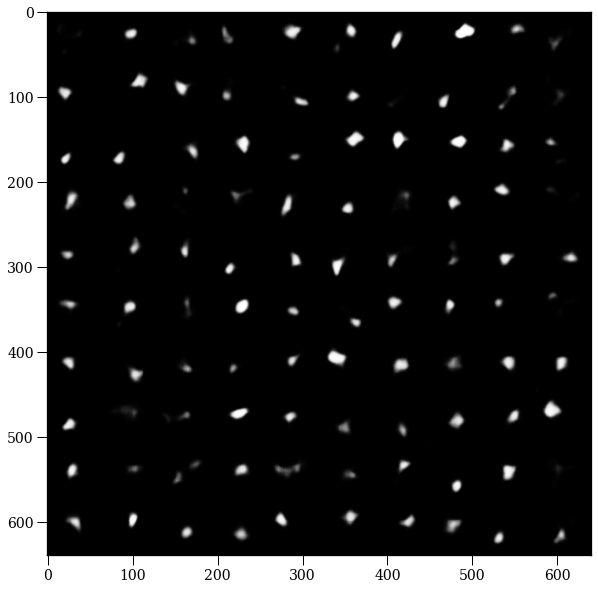

In [10]:
model = load_model(model_best)

n = 10
figure = np.zeros((digit_size * n, digit_size * n))

for j in range(n):
    z_sample = np.random.normal(size=10 * 100).reshape(100, 10)
    z_sample = torch.tensor(z_sample).float().cuda()
    x_decoded = model.decoder(z_sample)
    x_decoded = x_decoded.cpu().detach().numpy()
    digit = x_decoded.reshape(100, digit_size, digit_size, 1)
    for i in range(n):
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit[i, :, :, 0]

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()